# **EDA on Quora Question Dataset (QQD)**

Dataset : https://www.kaggle.com/competitions/quora-question-pairs/data

*Key features* about the data :

1. Data is labelled - `Binary Classification ()` problem

2. Labels have been supplied by humans, so truth labels are inherently subjective. Therefore, the `labels` on this dataset should be taken as informed and `not 100% accurate`.

---

**Problem Statement** 

`Given two questions we have to classify whether they are duplicates or not`.

---

**Background**

Currently, Quora uses a `Random Forest model` to identify duplicate questions.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("drive/MyDrive/Quora_Dataset/train.csv")

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df = df.drop(['id'], axis = 1)    # Dropped the id_column

In [ ]:
df.sample(10)

,qid1,qid2,question1,question2,is_duplicate
109021,178997,66399,Are there circumstances ever likely for a PPF ...,Under what circumstances would the production ...,0
7198,14072,14073,How can negative decibels exist?,How can there be negative decibels?,1
124448,200960,124462,How do you make hair grow faster overnight?,What should I do to grow my hair in a week?,1
279833,399314,399315,If elections were to happen in Bengal in this ...,Has Mamata Banerjee done more harm to Bengal t...,0
71202,122572,122573,Why is India not ready to resolve the Kashmir ...,Why is India against any kind of UN interventi...,1
283216,403278,403279,Could a 747 jumbo jet float on water?,How many engines does a jumbo jet have?,0
195805,296354,296355,"What is the best way to say ""NO""?",What is the best way to say no to someone?,1
387572,519891,519892,Why do people laugh for no reason?,Why do people laugh at dumb people?,0
271583,389694,389695,Can I be a nurse even when I have medical cond...,What are the differences between a Confederate...,0
197426,298384,298385,What is the difference between READ TABLE <ITA...,Why infotypes are used in SAP HR? Why not tables?,0


In [ ]:
print("Number of Question pairs :", df.shape[0])
print(df.shape)

Number of Question pairs : 404290
(404290, 5)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404290 non-null  int64 
 1   qid2          404290 non-null  int64 
 2   question1     404289 non-null  object
 3   question2     404288 non-null  object
 4   is_duplicate  404290 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 15.4+ MB


In [ ]:
df.isnull().sum()

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

> There are few `missing values` in the *question1* and  *question2* columns.

- Can remove these few rows since the data is large enough or can think of other ways as well.

In [ ]:
# Dropping the Null values rows
df = df.dropna()
print(df.shape)

(404287, 5)


In [ ]:
df.duplicated().sum()

0

> `No duplicate rows` in the data

In [ ]:
print(df['is_duplicate'].value_counts())  # Number of duplicate and Non-duplicate pairs

0    255024
1    149263
Name: is_duplicate, dtype: int64


In [ ]:
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)

0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64


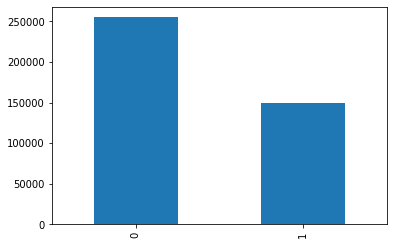

In [ ]:
df['is_duplicate'].value_counts().plot(kind='bar')

> Nearly `36.92` % of the rows provided are for duplicate pair examples.
> So it's an `Unbalanced dataset`

In [ ]:
# Repeated and unique Questions

# https://pandas.pydata.org/docs/reference/api/pandas.Series.html (pd.series)

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())   # Merge all the qids in one list and apply pd.series
# print(qid)
# print(qid.value_counts())  # prints how many times a questions is repeated is desc order

In [ ]:
rep = qid.value_counts() > 1                   # ids whose count > 1 are repeated questions

# print(rep)                                   # converts values to boolean
# print(rep[rep])

print("Number of Unique questions:", len(np.unique(df[['qid1', 'qid2']].values)))
print('Number of questions getting repeated:',rep[rep].shape[0])

Number of Unique questions: 537929
Number of questions getting repeated: 111778


> Among total **808574** questions in both columns combined, we have `537929 unique questions` (Union) and rest all questions are repeatitions of these unique questions. And around **111778** questions are getting repeated.

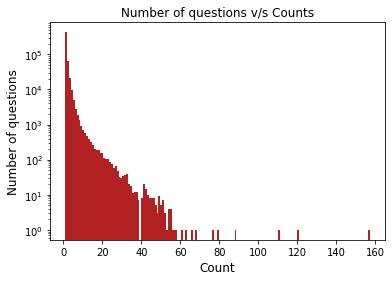

In [ ]:
plt.hist(qid.value_counts().values,bins=160,color=['firebrick'])
plt.yscale('log')
plt.title("Number of questions v/s Counts")
plt.xlabel('Count',fontsize=12)
plt.ylabel('Number of questions',fontsize=12)
plt.show()

> **(Note : Log scale on y-axis)**

- Majority of the questions occurs only once in the dataset.
- Few questions are repeated more than 50 times as well.
- Maximum times a question is repeated is nearly 160 ( To be precise 157 ) 

##### **FEATURE ENGINEERING ON THE DATASET**

- Character length of a question
- Number of words in a question
- Number of common words in both questions
- Total unique words in both questions
- Word share ( Jaccard similarity )

In [ ]:
# Character length of a question

df["len1"] = df["question1"].str.len()
df["len2"] = df["question2"].str.len()

In [ ]:
# Number of words
df["word1"] = df["question1"].str.strip().str.split().str.len()
df["word2"] = df["question2"].str.strip().str.split().str.len()

In [ ]:
# Number of common words

def to_lower(d):
  a = [[x.lower() for x in s] for s in d]
  return a 

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1|w2))

In [ ]:
df['common_words'] = df.apply(common_words, axis=1)
df['word_total'] = df.apply(total_words, axis=1)            # ? Should it be union or sum of unique words in both
df.head()

# In common words : Since we are using set to find intersection, if a word occurs twice in both questions it will be counted as 1 common

,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,common_words,word_total
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10,13
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,16
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,20
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2,18


In [ ]:
df['word_share'] = round(df['common_words']/df['word_total'],2)
df.head()

,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,common_words,word_total,word_share
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10,13,0.77
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,16,0.25
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,20,0.20
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19,0.00
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2,18,0.11


In [ ]:
# import nltk
# from nltk import unigram,bigrams, trigrams, word_tokenize
# from collections import Counter, defaultdict
# from collections import OrderedDict
# import operator

# def diff_ngram(sent_a, sent_b, num):

#     a = unigram(sent_a, num)
#     b = unigram(sent_b, num) 
#     common = [] 
#     cnt = 0 
#     for i in a:
#         for j in b:
#             if i == j:
#                 cnt += 1
#                 common.append(i)
  
#     return cnt/len(a)

# df['unigram_dist'] = df.apply(N, axis=1)

Minimum characters 1
Maximum characters 623
Average number of characters 59


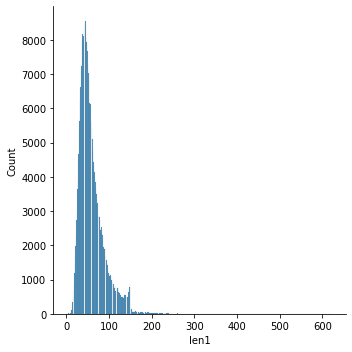

In [ ]:
# Question lengths statistics

sns.displot(df['len1'])
print('Minimum characters',df['len1'].min())
print('Maximum characters',df['len1'].max())
print('Average number of characters',int(df['len1'].mean()))

Minimum characters 1
Maximum characters 1169
Average num of characters 60


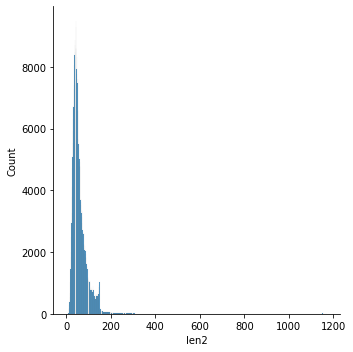

In [ ]:
sns.displot(df['len2'])
print('Minimum characters',df['len2'].min())
print('Maximum characters',df['len2'].max())
print('Average num of characters',int(df['len2'].mean()))

In [ ]:
# Questions with len = 1,2,3 Are they of any use ?

df.loc[df['len1'] == 1]
#df.loc[df['len2'] == 1]

,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,common_words,word_total,word_share
3306,6553,6554,.,Why is Cornell's endowment the lowest in the I...,0,1,56,1,10,0,10,0.0
13016,25026,25027,?,Why should one not work at Google?,0,1,34,1,7,0,8,0.0
20794,39204,39205,?,What is the Gmail tech support help phone number?,0,1,49,1,9,0,10,0.0
96725,161071,161072,?,"Who are Moses, Noah and Exodus?",0,1,31,1,6,0,7,0.0
104101,171925,171926,?,"Problem of solving a problem is not a problem,...",0,1,149,1,29,0,18,0.0
108978,178936,178937,i,What questions to ask any drdummer?,0,1,35,1,6,0,7,0.0
115347,188110,52215,o,Where can I watch free streaming movies online?,0,1,47,1,8,0,9,0.0
134403,214814,214815,?,What is your take on the undercover report tha...,0,1,144,1,25,0,24,0.0
151922,188110,238787,o,What is this - “This website/URL has been bloc...,0,1,132,1,20,0,20,0.0
158778,247989,48850,A,Do men forgive their wives when they cheat on ...,0,1,51,1,10,0,11,0.0


Minimum words 1
Maximum words 125
Average num of words 10


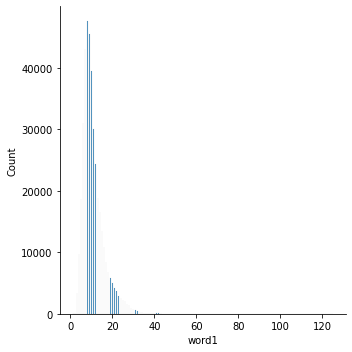

In [ ]:
sns.displot(df['word1'])
print('Minimum words',df['word1'].min())
print('Maximum words',df['word1'].max())
print('Average num of words',int(df['word1'].mean()))

Minimum words 1
Maximum words 237
Average num of words 11


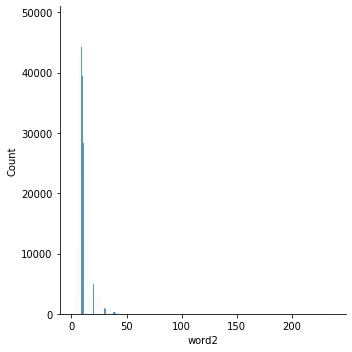

In [ ]:
sns.displot(df['word2'])

print('Minimum words',df['word2'].min())
print('Maximum words',df['word2'].max())
print('Average num of words',int(df['word2'].mean()))

In [ ]:
# Questions with words = 1,2,3 Are they of any use, seems useful ?

df.loc[df['word1'] == 1]
#df.loc[df['len2'] == 1]

,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,common_words,word_total,word_share
3306,6553,6554,.,Why is Cornell's endowment the lowest in the I...,0,1,56,1,10,0,10,0.0
13016,25026,25027,?,Why should one not work at Google?,0,1,34,1,7,0,8,0.0
17682,33561,33562,deleted,Which website will be suitable for downloading...,0,7,67,1,10,0,11,0.0
20794,39204,39205,?,What is the Gmail tech support help phone number?,0,1,49,1,9,0,10,0.0
23305,33561,43661,deleted,Which are some best websites for downloading n...,0,7,74,1,10,0,11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
356434,147899,485756,Deleted.,Do gay men find red headed men more attractive...,0,8,78,1,15,0,12,0.0
357127,486520,146954,H,Should I forgive the cheater?,0,1,29,1,5,0,6,0.0
365317,33561,365465,deleted,From which site I can download GTA 4 game?,0,7,42,1,9,0,10,0.0
381124,512812,512813,no,I have a BS and MPH and hate my job. I found t...,0,2,122,1,27,0,25,0.0


### **Word share / Jaccard Similarity Plot**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


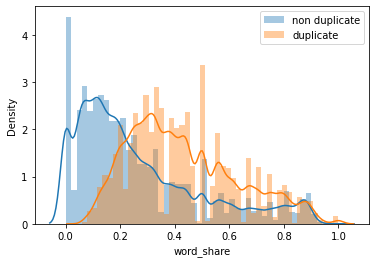

In [ ]:
sns.distplot(df[df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

## **Some data eyeballing to the cases where `word share is high` but still they are `not duplicates`.**

- **Note** : `Word_share = Jaccard Similarity (JC)`

- Number of shared terms over the number of all unique terms in both strings 





In [ ]:
vis_df = df.loc[(df['word_share'] == 1) & (df['is_duplicate']==0)]
vis_df[['question1','question2','word_share','is_duplicate']]

,question1,question2,word_share,is_duplicate
3204,Which laptop is the most suitable with the fol...,Which laptop is most suitable with the followi...,1.0,0
6279,Why is Google Chrome not working but Internet ...,Why is Internet Explorer not working but Googl...,1.0,0
16682,Why are natural resources important for us?,Why natural resources are important for us?,1.0,0
17946,Which laptop I should buy?,Which laptop should I buy?,1.0,0
34214,What does Stefano Tessaro think of Ben Y. Zhao...,What does Ben Y. Zhao think of Stefano Tessaro...,1.0,0
...,...,...,...,...
379510,How do you convert current source to voltage s...,How do you convert voltage source to current s...,1.0,0
379768,"What is the best thing about yourself, that ha...","What is the worst thing about yourself, that h...",1.0,0
385795,Why should I choose UT Dallas over Northeaster...,Why should I choose Northeastern University ov...,1.0,0
394521,How do wholesale and retail differ?,How do retail and wholesale differ?,1.0,0


⚡ Though questions have `Exact same (JC = 1)` vocabulary but `ordering` changes the meaning completely. This is where sementic nature is required to identify duplicates better.  

> Example : 
> - a) What kind of Asian guys do White girls like ?
> - b) What kind of Asian girls do White guys like ?

> Though some labels I feel are not appropriate and they should be duplicate indeed.
> - a) Which laptop I should buy ?
> - b) Which laptop should I buy ?

In [ ]:
vis_df = df.loc[(df['word_share'] >= 0.9) & (df['is_duplicate']==0)]
vis_df[['question1','question2','word_share','is_duplicate']]

# Use inetractive table and sort acc to word_share values to see 0.9 word_share values first

,question1,question2,word_share,is_duplicate
298,On what online platforms can I post ads for be...,What online platforms can I post ads for beer ...,0.92,0
1037,What hotel in Shimla Hill-station would be saf...,What hotel in Dehradun Hill-station would be s...,0.90,0
1368,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...,0.90,0
1470,How much does an Ola Mini cab earn on average ...,How much does an Ola Mini cab earn on average ...,0.90,0
2109,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...,0.90,0
...,...,...,...,...
403222,What hotel in Srinagar Hill-station would be s...,What hotel in Pahalgam Hill-station would be s...,0.90,0
403361,What hotel in Saharanpur would be safe for unm...,What hotel in Nagpur would be safe for unmarri...,0.90,0
403712,Only 3 in 10 view Hillary Clinton as honest. H...,Only 3 in 10 view Hillary Clinton as compassio...,0.90,0
403779,What hotel in Darjeeling Hill-station would be...,What hotel in Wayanad Hill-station would be sa...,0.90,0


⚡ Though questions have `High word_share(JC)` vocabulary but a change of `Keyword` in the question changes it meaning.  

> Example : Negation sentences 
> - a) Who are the best science reporters not writing in English ?
> - b) Who are the best science reporters writing in English ?

> Example : Key noun is different 
> - a) How does a typical day in IIM C pass by ?
> - b) How does a typical day in IIM A pass by ?

> Example : More specification gets added
> - a) How much does it cost to study in Canada ?
> - b) How much does it cost to study medicine in Canada ?

In [ ]:
# Some more cases where data is lexically similar but not duplicates

vis_df = df.loc[(df['word_share'] >= 0.75) & (df['is_duplicate']==0)]
vis_df[['question1','question2','word_share','is_duplicate']]

,question1,question2,word_share,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.77,0
14,What are the laws to change your status from a...,What are the laws to change your status from a...,0.83,0
25,What are some tips on making it through the jo...,What are some tips on making it through the jo...,0.81,0
41,When can I expect my Cognizant confirmation mail?,When can I expect Cognizant confirmation mail?,0.88,0
42,"Can I make 50,000 a month by day trading?","Can I make 30,000 a month by day trading?",0.80,0
...,...,...,...,...
404203,Which professors from IIT Guwahati would you l...,Which Professors from IIT Delhi would you love...,0.85,0
404207,Is it safe to drink tap water in Canada?,Is it safe to drink tap water in Pune?,0.80,0
404209,What is the fastest way to sign into Yahoo Mail?,What is the fastest way to sign into Yahoo Mai...,0.75,0
404285,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0.79,0


⚡ Though questions have `Moderately high word_share(JC)` but a change of `Keyword` in the question changes it meaning.  

- **Observation** - In this chart we see short sentences whereas earlier there were long sentences, that's because changing a single word in small sentences drops down the Jaccard similarity more (Obvious though).

In [ ]:
# More non-duplicate pairs visualization

threshold = 0.4
df.loc[(df['word_share'] >= threshold)][:200]


,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,common_words,word_total,word_share
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10,13,0.77
8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,31,37,8,8,6,10,0.60
11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1,43,38,9,8,5,12,0.42
12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1,36,39,7,8,6,9,0.67
13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1,43,38,7,6,5,8,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...
592,1182,1183,How is time travel possible?,Do you think time travel is possible?,1,28,37,5,7,4,8,0.50
593,1184,1185,How can one get a fuller face?,How do I do to get fuller face?,1,30,31,7,8,4,10,0.40
594,1186,1187,Is it too late for me at the age of 25 thinkin...,I want to start my career as a photographer at...,1,81,73,18,17,10,25,0.40
609,1216,1217,How can eating prunes help during a constipation?,Does eating prunes help with constipation?,1,49,42,8,6,4,10,0.40


## **Some data eyeballing to the cases where `word share is low` but still they are `duplicates`.**

In [ ]:
vis_df = df.loc[(df['word_share'] <= 0.8) & (df['is_duplicate']==1)]
vis_df[['question1','question2','word_share','is_duplicate']][:1000]

,question1,question2,word_share,is_duplicate
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",0.35,1
7,How can I be a good geologist?,What should I do to be a great geologist?,0.33,1
11,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,0.42,1
12,What can make Physics easy to learn?,How can you make physics easy to learn?,0.67,1
13,What was your first sexual experience like?,What was your first sexual experience?,0.62,1
...,...,...,...,...
2746,Is coaching necessary for cracking the GATE?,Is it necessary to go for coaching for GATE pr...,0.33,1
2748,What are the differences between CSE and IT/ISE?,What is the difference between CSE and IT engg?,0.42,1
2749,If a war breaks out between India and Pakistan...,Who will win if a war starts between India and...,0.44,1
2761,What are the daily life examples of shear stress?,What is shear stress? Also give any real life ...,0.31,1


What inference can we make from above ?

In [ ]:
dup_word_share = (df.loc[df['is_duplicate']==1])['word_share']
non_dup_word_share = (df.loc[df['is_duplicate']==0])['word_share']

print("Mean word_share of non-duplicate pairs : " , non_dup_word_share.mean() )
print("Mean word_share of duplicate pairs : " , dup_word_share.mean() )

# box_data = [non_dup_word_share[0]] 

Mean word_share of non-duplicate pairs :  0.26442409341867656
Mean word_share of duplicate pairs :  0.430852321070857


Text(0, 0.5, 'Word_Share')

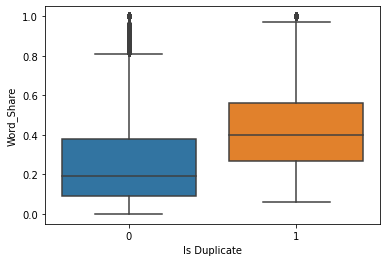

In [ ]:
ax = sns.boxplot( data=([non_dup_word_share,dup_word_share]))
# ax = sns.stripplot( data=([non_dup_word_share,dup_word_share]), color=".20")
plt.xlabel("Is Duplicate")
plt.ylabel("Word_Share")

In [ ]:
import altair as alt
from vega_datasets import data

alt.Chart(df[:5000]).mark_point().encode(
    x='len1',
    y='len2',
    color='is_duplicate',
).interactive()

alt.Chart(...)

In [ ]:
# def Unigram_distance(dataset):

#   model = defaultdict(lambda : 0)
#   total_count = 0 
#   for sentence in dataset:
#     sentence = nltk.word_tokenize(sentence)
#     for w1 in sentence:
#       model[w1] += 1
#       total_count += 1 ;

#   for w1 in model:
#       model[w1] /= total_count
  
#   return model

In [ ]:
profile = ProfileReport(df, title="Quora", html={'style':{'full_width':True}})

TypeError: ignored

In [ ]:
profile.to_notebook_iframe()

In [ ]:
# Preprocessing - ? se pehle space daaldo or remove it

In [ ]:
drive.flush_and_unmount()